In [51]:
import pandas as pd
import numpy as np
import lattice.utils.paths as paths
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union
from pathlib import Path

    
def aggregate_data(dataset: Union[str,Path]):
    data = dict()
    for path in dataset.iterdir():
        df = pd.read_parquet(path)
        df['log_ret'] = np.log(df.close) - np.log(df.close.shift(1))
        data[path.name.split('.')[0]] = df.iloc[1:]
    return data

**Research Plan**

1. Start with returns then add more features if models fail

## Loading Data

In [52]:
dirs = list(paths.data.iterdir())
print(dirs[1])
data = aggregate_data(dirs[1])

/home/magi/projects/lattice/lattice/data/365_days_900_seconds


In [53]:
eth = data['ETH_USD']
btc.describe()

,time,open,high,low,close,volume,log_ret
count,3.506300e+04,35063.000000,35063.000000,35063.000000,35063.000000,3.506300e+04,35063.000000
mean,1.634750e+12,45529.891424,45649.291960,45407.217979,45529.530103,6.342355e+05,-0.000008
std,9.103540e+09,8635.994731,8645.348265,8624.682613,8635.786449,1.289236e+06,0.004230
min,1.618982e+12,29222.000000,29511.000000,28829.000000,29216.000000,0.000000e+00,-0.086133
25%,1.626866e+12,38966.000000,39073.500000,38850.500000,38966.500000,5.741408e+04,-0.001854
50%,1.634749e+12,44112.000000,44205.000000,43995.000000,44109.000000,2.387360e+05,0.000000
75%,1.642633e+12,49984.500000,50138.000000,49857.500000,49986.000000,7.023887e+05,0.001822
max,1.650517e+12,68724.000000,69045.000000,68505.000000,68724.000000,3.666873e+07,0.105444


## Inspecting Correlations

In [117]:
df = pd.DataFrame()
for market in data:
    df[market] = data[market].log_ret

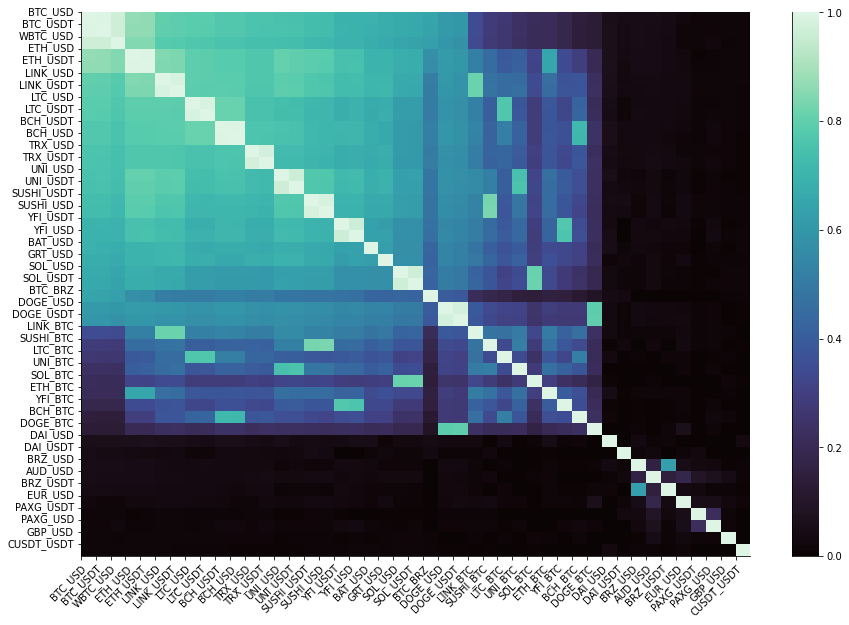

In [124]:
N = 45
S = df.corr()
labels = S['BTC_USD'].sort_values(ascending=False).index[:N]
S = S[labels].loc[labels]
fig, ax = plt.subplots(figsize = (15,10))
ax = sns.heatmap(S, vmin=0, vmax=1, cmap='mako')
ax.set_xticks(np.arange(len(labels)), labels=labels)
ax.set_yticks(np.arange(len(labels)), labels=labels)
plt.setp(
    ax.get_xticklabels(), 
    rotation=45, 
    ha="right",
    rotation_mode="anchor"
)
sns.despine()
plt.show()